# ITCS 6100 - Group 12 project
## NREL Wind Integration National Dataset
### Data pulled from wtk-us.h5 file from the NREL dataset
### located: arn:aws:s3:::nrel-pds-hsds/nrel/wtk-us.h5

In [2]:
# At Terminal: Install HSDS from the HDF group to access the .h5 file
# pip install --user h5pyd
# pip install pyproj

In [3]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil

## Save the .h5 data file so it can be viewed via Python

In [7]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r', endpoint='https://developer.nrel.gov/api/hsds', bucket="nrel-pds-hsds", api_key='CG74xbnQohlDJZdN2hn0QBAZnNbKn78SMyFZWahg')

In [8]:
print(f.keys())
list(f.attrs)

KeysView(<HDF5 file "wtk-us.h5" (mode r)>)


['history']

## List of Datapoints / Features

In [10]:
# list datapoints]
list(f)

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

## Exploring the data
### Saving an object with just 1 feature of the dataset (windspeed_100m)

In [11]:
dset = f['windspeed_100m']

In [13]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)

### Creating an index to see dataset from just the year 2007

In [14]:
# Index for 2007
twoThousandSeven = dt.loc[(dt.datetime >= '2007-01-01') & (dt.datetime < '2008-01-01')].index
twoThousandSeven

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', length=8760)

### Selecting a location
**In order to traverse the data by location, we need to convert location latitude and longitude into X/Y indices** <br>**Using https://www.findlatitudeandlongitude.com/ I chose Charlotte and Raleigh NC as example locations**
<br>**The function "indicesForCoord" does just that**

In [17]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

CharlotteNC = (35.34, -80.83)
CharlotteNC_idx = indicesForCoord( f, CharlotteNC[0], CharlotteNC[1] )

print("y,x indices for Charlotte NC: \t\t {}".format(CharlotteNC_idx))
print("Coordinates of Charlotte NC: \t {}".format(CharlotteNC))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][CharlotteNC_idx[0]][CharlotteNC_idx[1]]))

y,x indices for Charlotte NC: 		 (694, 2158)
Coordinates of Charlotte NC: 	 (35.34, -80.83)
Coordinates of nearest point: 	 (35.337662, -80.83313)


In [18]:
# The 2007 timeseries data for a point in Charlotte NC
%time tseriesSeven = dset[min(twoThousandSeven):max(twoThousandSeven)+1, CharlotteNC_idx[0], CharlotteNC_idx[1]]

CPU times: user 7.53 ms, sys: 0 ns, total: 7.53 ms
Wall time: 2.58 s


## Windspeed at 100m/s in Charlotte NC - over the year 2007
### We squeeze the data down to just 1 year and 1 location, so analysis and modeling runs faster

Text(0.5, 1.0, 'Charlotte NC Windspeed in 2007')

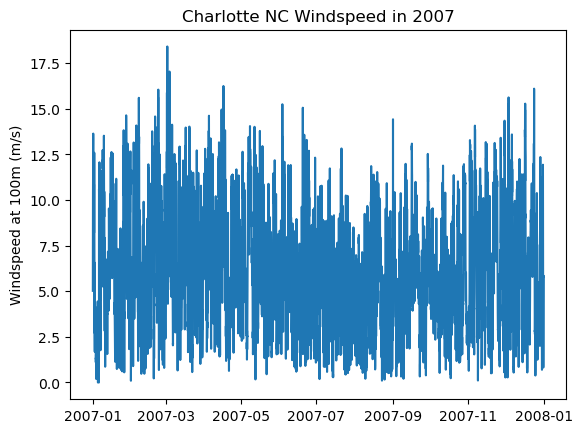

In [19]:
plt.plot(dt.iloc[twoThousandSeven,].datetime, tseriesSeven)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Charlotte NC Windspeed in 2007")

In [20]:
# The timeseries data for all 7 years for a point in Raleigh NC
RaleighNC_idx = indicesForCoord(f, 35.78, -78.64)
%time tseries = dset[:,RaleighNC_idx[0],RaleighNC_idx[1]]

CPU times: user 3.15 ms, sys: 2.46 ms, total: 5.61 ms
Wall time: 14.2 s


## Windspeed at 100m/s in Raleigh NC - over the full dataset of time
### We squeeze the data down to just 1 location but keep all 7 years (2007 to 2013)

Text(0.5, 1.0, 'Raliegh NC Windspeed 2007-2013')

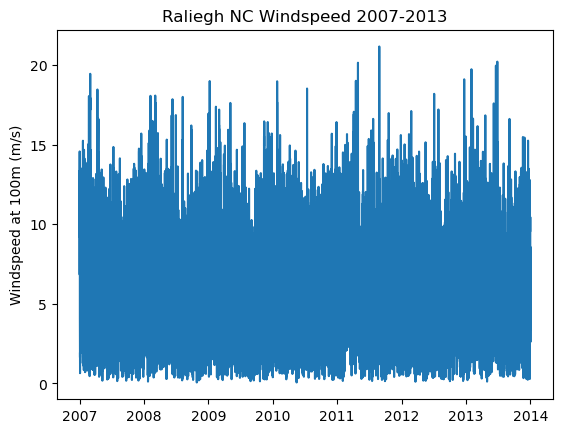

In [21]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Raliegh NC Windspeed 2007-2013")

## Saving as a DataFrame
### One way we could analyze the data without it being overwhelmingly large is feature reduction:
### Here I've reduced down to 1 feature of each type (Temperature, Windspeed, Pressure and Precipitation Rate)

In [24]:
# save 4 features in a dataframe for all dates of Charlotte NC
%time df = pd.DataFrame({"temperature_100m": f['temperature_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "windspeed_100m": f['windspeed_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "pressure_100m": f['pressure_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "precipitationrate_0m": f['precipitationrate_0m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]]},\
                         index=map(dateutil.parser.parse, f["datetime"][:]))
df.index.name = 'datetime'
df.head()

CPU times: user 2.38 s, sys: 43.5 ms, total: 2.42 s
Wall time: 1min 41s


,temperature_100m,windspeed_100m,pressure_100m,precipitationrate_0m
datetime,,,,
2007-01-01 00:00:00,287.202057,5.023346,98045.593750,0.366211
2007-01-01 01:00:00,288.172546,8.404800,97965.937500,0.366211
2007-01-01 02:00:00,288.593719,8.697777,97940.304688,0.000000
2007-01-01 03:00:00,289.243744,10.333565,97819.453125,0.000000
2007-01-01 04:00:00,290.144043,10.852379,97728.812500,24.903076


### Example scatter plot of the DataFrame (Charlotte NC): 
### Analyzing relationship between Precipitation Rate and Temperature

<AxesSubplot: xlabel='temperature_100m', ylabel='precipitationrate_0m'>

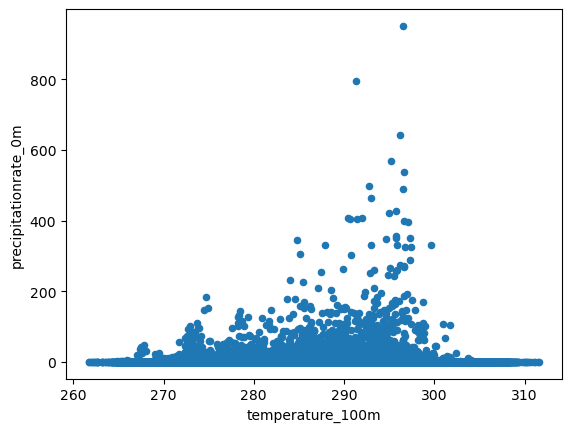

In [25]:
df.plot(x='temperature_100m', y='precipitationrate_0m', kind='scatter')

### Example bar chart of the DataFrame (Charlotte NC): 
### Analyzing the precipitation rate changing over time

<AxesSubplot: xlabel='datetime'>

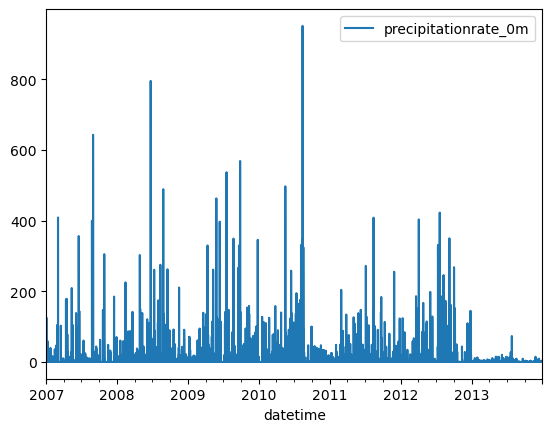

In [28]:
df.plot(y='precipitationrate_0m', use_index=True)

In [29]:
df.to_csv('CharlotteNC_Wind.csv')